In [1]:
import pandas as pd

# 데이터 파일 URL
url = "https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz"

# 데이터를 데이터프레임으로 읽기
df = pd.read_csv(url, compression='gzip')

# 데이터프레임 확인
print(df.head())

   session  year country country_name             speaker position  \
0       25  1970     ALB      Albania             Mr. NAS      NaN   
1       25  1970     ARG    Argentina  Mr. DE PABLO PARDO      NaN   
2       25  1970     AUS    Australia         Mr. McMAHON      NaN   
3       25  1970     AUT      Austria  Mr. KIRCHSCHLAEGER      NaN   
4       25  1970     BEL      Belgium          Mr. HARMEL      NaN   

                                                text  
0  33: May I first convey to our President the co...  
1  177.\t : It is a fortunate coincidence that pr...  
2  100.\t  It is a pleasure for me to extend to y...  
3  155.\t  May I begin by expressing to Ambassado...  
4  176. No doubt each of us, before coming up to ...  


## 말뭉치 통계 확인

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [3]:
print(repr(df.iloc[2666]["text"[0:200]]))
print(repr(df.iloc[4729]["text"[0:200]]))

"\ufeffIt is indeed a pleasure for me and the members of my delegation to extend to Ambassador Garba our sincere congratulations on his election to the presidency of the forty-fourth session of the General Assembly. His election to this high office is a well-deserved tribute to his personal qualities and experience. I am fully confident that under his able and wise leadership the Assembly will further consolidate the gains achieved during the past year.\nMy delegation associates itself with previous speakers in expressing its appreciation of the dedicated efforts of his predecessor, His Excellency Mr. Dante Caputo, for the exemplary manner in which he discharged his duties as President of the forty-third session of the General Assembly.\nAs in previous years, my delegation wishes to note its satisfaction with and gratitude for the assiduous and unrelenting efforts exerted by the Secretary-General of the United Nations in the cause of peace and international harmony. We pay a tribute to

In [4]:
import re
df['paragraphs'] = df['text'].map(lambda text: re.split('[.?!]\s*\n', text))
df['number_of_paragraphs'] = df['paragraphs'].map(len)

<Axes: xlabel='year'>

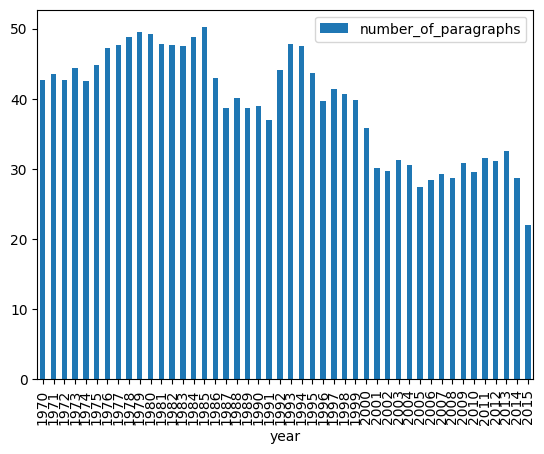

In [5]:
%matplotlib inline
df.groupby('year').agg({'number_of_paragraphs':'mean'}).plot.bar()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [7]:
# max_df = 0.7 -> 0.7로 설정된 경우, 특정 단어가 전체 문서의 70% 이상에서 등장하면 벡터에서 제외

# stopwords가 집합(set) 형태라면 리스트로 변환
stopwords = list(stopwords)  # stopwords가 집합이라면 필요

tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:406: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


<7507x24611 sparse matrix of type '<class 'numpy.float64'>'
	with 5364930 stored elements in Compressed Sparse Row format>

In [8]:
# 단락 및 연도만으로 구성된 데이터프레임 만들기
paragraph_df = pd.DataFrame([{'text':paragraph, "year":year}
                             for paragraphs, year in zip(df['paragraphs'], df['year'])
                                for paragraph in paragraphs if paragraph])
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df['text'])
tfidf_para_vectors

<282210x25165 sparse matrix of type '<class 'numpy.float64'>'
	with 9397018 stored elements in Compressed Sparse Row format>

## 젠심을 사용한 토픽 모델링

In [9]:
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords]
                           for paragraph in paragraph_df["text"]]

In [10]:
from gensim.corpora import Dictionary
dict_gensim_para = Dictionary(gensim_paragraphs)

In [11]:
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

In [12]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [13]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]
# vectors_gensim_para 행렬은 젠심을 사용한 모든 토픽 모델링 작업에 사용

## 젠심을 사용한 비음수 행렬 분해 수행

In [14]:
from gensim.models.nmf import Nmf

nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10, id2word=dict_gensim_para, kappa=0.1, eval_every=5, random_state=42)

In [15]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [16]:
display_topics_gensim(nmf_gensim_para)


Topic 00
  nations (0.03)
  united (0.02)
  human (0.02)
  rights (0.02)
  role (0.01)

Topic 01
  africa (0.02)
  south (0.02)
  people (0.02)
  government (0.01)
  republic (0.01)

Topic 02
  economic (0.01)
  development (0.01)
  countries (0.01)
  social (0.01)
  international (0.01)

Topic 03
  countries (0.02)
  developing (0.02)
  resources (0.01)
  sea (0.01)
  developed (0.01)

Topic 04
  israel (0.02)
  arab (0.02)
  palestinian (0.02)
  council (0.01)
  security (0.01)

Topic 05
  organization (0.02)
  charter (0.02)
  principles (0.01)
  member (0.01)
  international (0.01)

Topic 06
  problem (0.01)
  solution (0.01)
  east (0.01)
  situation (0.01)
  problems (0.01)

Topic 07
  nuclear (0.02)
  co (0.02)
  operation (0.02)
  weapons (0.02)
  disarmament (0.02)

Topic 08
  session (0.02)
  general (0.02)
  assembly (0.02)
  mr (0.02)
  president (0.02)

Topic 09
  world (0.02)
  peace (0.02)
  peoples (0.02)
  security (0.01)
  states (0.01)


## gensim에는 토픽 모델에 대한 품질 지표인 일관성 점수(coherence score)를 계산하는 코드가 존재

In [17]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para,
                                           texts=gensim_paragraphs,
                                           dictionary=dict_gensim_para,
                                           coherence='c_v')

nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

0.6510554194031981


## gensim을 사용한 LDA 실행

In [18]:
from gensim.models import LdaModel

lda_gensim_para = LdaModel(corpus=bow_gensim_para, id2word=dict_gensim_para,
                           chunksize=2000, alpha='auto', eta='auto',iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [19]:
display_topics_gensim(lda_gensim_para)


Topic 00
  climate (0.12)
  convention (0.03)
  pacific (0.02)
  environmental (0.02)
  sea (0.02)

Topic 01
  country (0.05)
  people (0.05)
  government (0.03)
  national (0.02)
  support (0.02)

Topic 02
  nations (0.10)
  united (0.10)
  human (0.04)
  security (0.03)
  rights (0.03)

Topic 03
  international (0.03)
  community (0.01)
  efforts (0.01)
  new (0.01)
  global (0.01)

Topic 04
  africa (0.06)
  african (0.06)
  continent (0.02)
  terrorist (0.02)
  crimes (0.02)

Topic 05
  world (0.05)
  years (0.02)
  today (0.02)
  peace (0.01)
  time (0.01)

Topic 06
  peace (0.03)
  conflict (0.02)
  region (0.02)
  people (0.02)
  state (0.02)

Topic 07
  south (0.10)
  sudan (0.05)
  china (0.04)
  asia (0.04)
  somalia (0.04)

Topic 08
  general (0.10)
  assembly (0.09)
  session (0.05)
  president (0.04)
  secretary (0.04)

Topic 09
  development (0.07)
  countries (0.05)
  economic (0.03)
  sustainable (0.02)
  2015 (0.02)


## 일관성 점수 계산
 - 젠심은 주제 일관성이 계산이 가능하다. 방법 자체는 세분화, 확률 추정, 확인 측도 계산, 집계로 구성된 4단계 절차

In [20]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics])/len(top_topics)
print("Average topic coherence: %.4f." % avg_topic_coherence)

Average topic coherence: -2.4709.


In [21]:
print(top_topics)

[([(0.10494908, 'general'), (0.089620255, 'assembly'), (0.053627368, 'session'), (0.040209845, 'president'), (0.035686057, 'secretary')], -1.5361194241843663), ([(0.10334143, 'nations'), (0.101547, 'united'), (0.036380447, 'human'), (0.03241845, 'security'), (0.029995637, 'rights')], -1.7014902754187737), ([(0.048105046, 'country'), (0.0475206, 'people'), (0.031239321, 'government'), (0.020561239, 'national'), (0.020318916, 'support')], -1.8485895463251694), ([(0.027940523, 'peace'), (0.023427604, 'conflict'), (0.022910627, 'region'), (0.019756153, 'people'), (0.016293647, 'state')], -1.9729985026779555), ([(0.0454433, 'world'), (0.017748818, 'years'), (0.015198159, 'today'), (0.013141295, 'peace'), (0.012536756, 'time')], -1.9743434414778658), ([(0.02997288, 'international'), (0.011996245, 'community'), (0.011175989, 'efforts'), (0.010160265, 'new'), (0.008497909, 'global')], -2.020282339658643), ([(0.072996534, 'development'), (0.047760777, 'countries'), (0.029313015, 'economic'), (0

In [22]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

[(-1.5361194241843663, 'general assembly session president secretary'),
 (-1.7014902754187737, 'nations united human security rights'),
 (-1.8485895463251694, 'country people government national support'),
 (-1.9729985026779555, 'peace conflict region people state'),
 (-1.9743434414778658, 'world years today peace time'),
 (-2.020282339658643, 'international community efforts new global'),
 (-2.7269347656599225, 'development countries economic sustainable 2015'),
 (-2.9089975883502706, 'climate convention pacific environmental sea'),
 (-3.868068477050875, 'africa african continent terrorist crimes'),
 (-4.1515707817343195, 'south sudan china asia somalia')]

## 최적의 주제 개수 탐색
  - 토픽 모델의  품질은 이전에 도입한 일관성 점수(Coherence)로 측정할 수 있다. 최고의 일관성 점수를 찾기 위해 LDA 모델을 사용해 다른 수의 주제에 대해 일관성 점수를 계산한다.
  최적의 주제 수를 제공하는 가장 높은 점수를

## gensim을 사용한 계층적 디리클레 절차 생성
  - 우리에게 더 넓은 주제를 먼저 제공하고 그 아래에 일부 하위 주제를 제공하면 더 좋을 것이다.

In [23]:
from gensim.models import HdpModel
hdp_gensim_para = HdpModel(corpus=bow_gensim_para, id2word=dict_gensim_para)

In [24]:
hdp_gensim_para.print_topics(num_words=10)

[(0,
  '0.014*nations + 0.014*united + 0.011*international + 0.009*world + 0.009*peace + 0.008*states + 0.008*countries + 0.006*security + 0.005*people + 0.005*general'),
 (1,
  '0.018*countries + 0.013*development + 0.013*international + 0.013*economic + 0.012*world + 0.009*nations + 0.008*developing + 0.008*united + 0.005*new + 0.004*states'),
 (2,
  '0.012*people + 0.009*united + 0.009*africa + 0.008*international + 0.008*nations + 0.007*south + 0.007*world + 0.006*countries + 0.006*peace + 0.005*states'),
 (3,
  '0.015*general + 0.014*nations + 0.013*united + 0.012*assembly + 0.011*session + 0.009*international + 0.008*mr + 0.007*world + 0.007*president + 0.007*peace'),
 (4,
  '0.012*peace + 0.011*international + 0.010*united + 0.009*nations + 0.008*security + 0.007*people + 0.006*world + 0.006*countries + 0.006*states + 0.005*council'),
 (5,
  '0.011*international + 0.010*nations + 0.010*united + 0.009*countries + 0.009*world + 0.006*nuclear + 0.006*states + 0.006*peace + 0.006*ec

## 클러스터링을 통한 텍스트 데이터 구조 파악
  - 토픽 모델링과 비교할 때 각 문서가 정확히 하나의 클러스터에 할당하는 것이 중요하다.

In [25]:
from sklearn.cluster import KMeans
k_means_text = KMeans(n_clusters=10, random_state=42)
k_means_text.fit(tfidf_para_vectors)

KMeans(n_clusters=10, random_state=42)

KMeans(n_clusters=10, random_state=42)

In [26]:
import numpy as np
np.unique(k_means_text.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 20922,  10826,  10457,  11364, 132141,   9588,  39899,  19609,
         18333,   9071]))

<Axes: xlabel='cluster'>

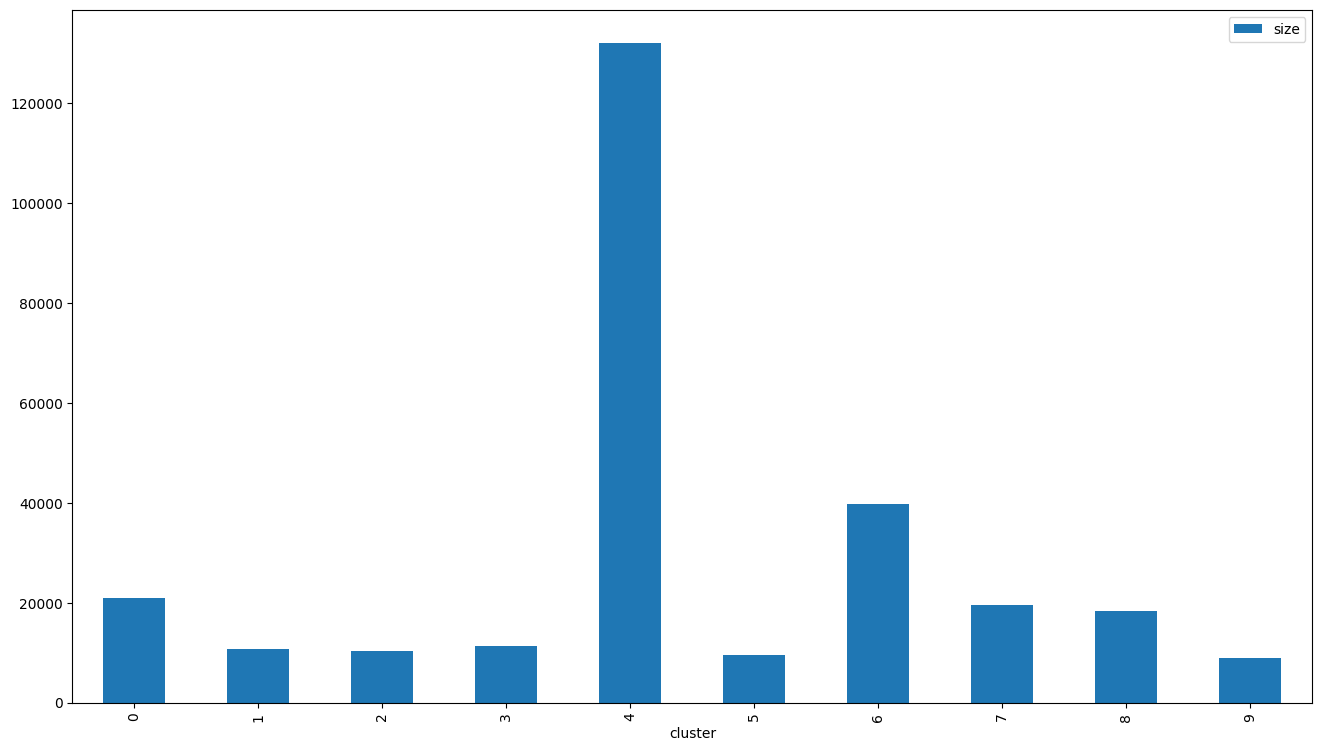

In [27]:
sizes = []
for i in range(10):
  sizes.append({"cluster":i, "size":np.sum(k_means_text.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))

In [28]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
def wordcloud_clusters(model, vectors, features, no_top_words=40):
  for cluster in np.unique(model.labels_):
    size={}
    words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
    largest = words.argsort()[::-1]
    for i in range(0, no_top_words):
      size[features[largest[i]]] = abs(words[largest[i]])
    wc = WordCloud(background_color="white", max_words=100,
                   width=960, height=540)
    wc.generate_from_frequencies(size)
    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

## 클러스터링을 통한 텍스트 데이터 구조 파악
  - 클러스터가 더 뚜렷하다. 즉 단어가 더욱 구체적이다.

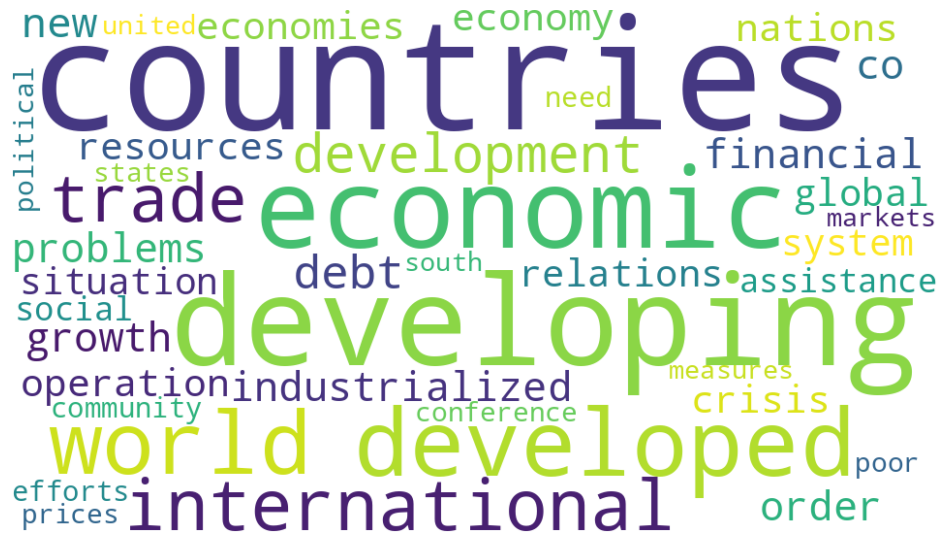

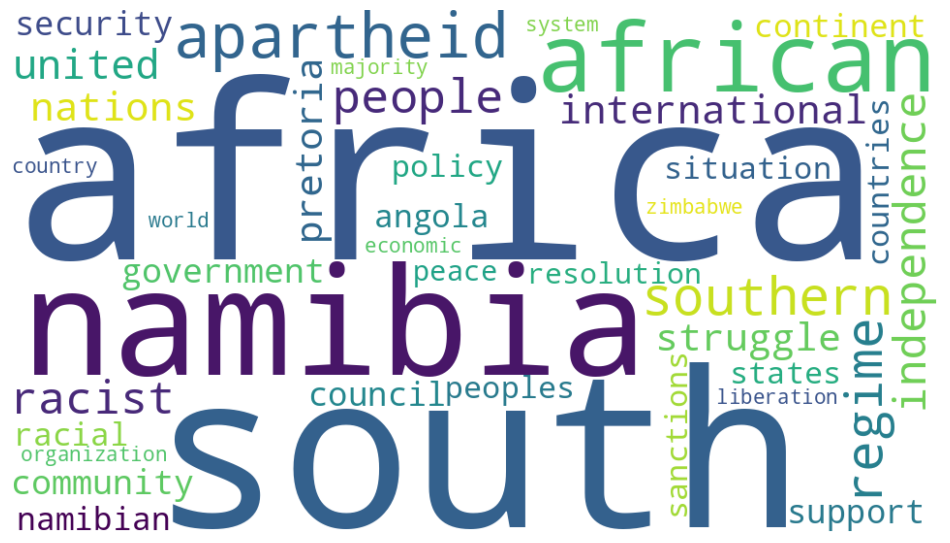

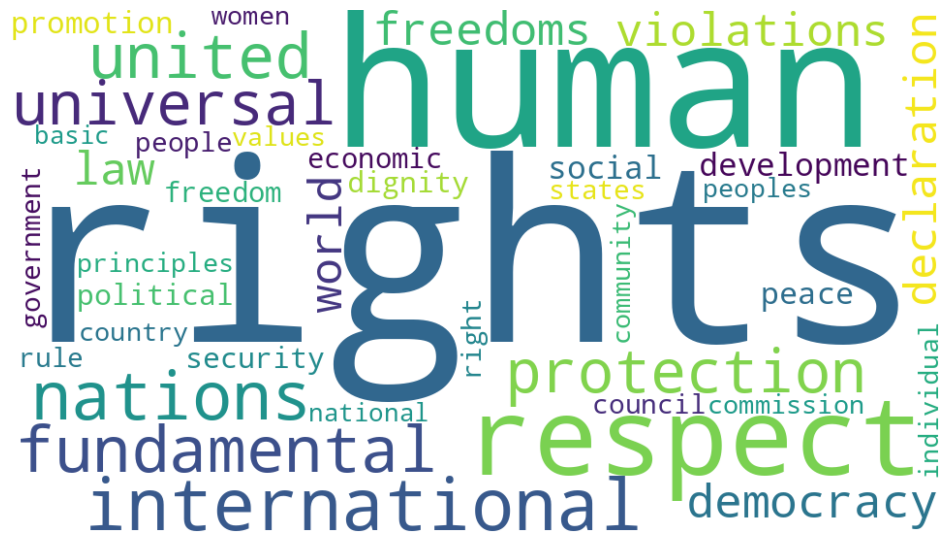

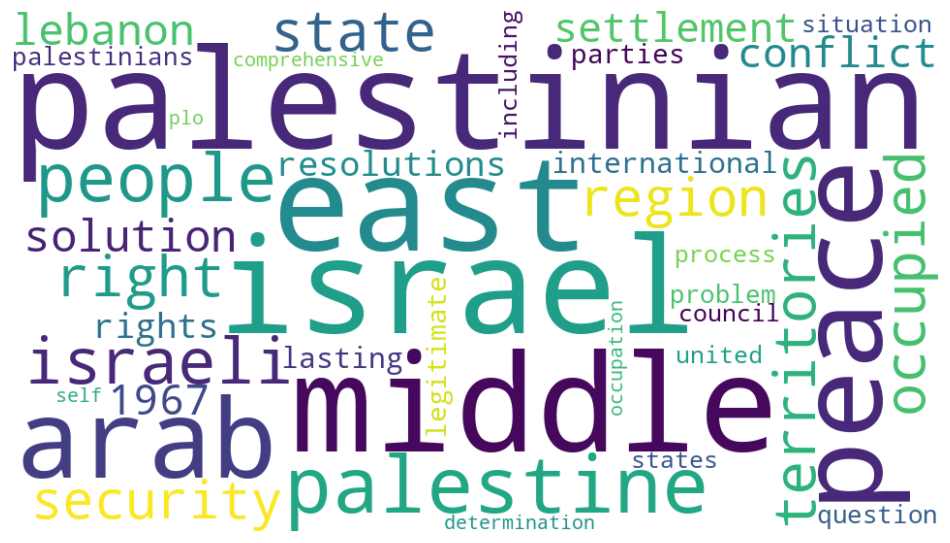

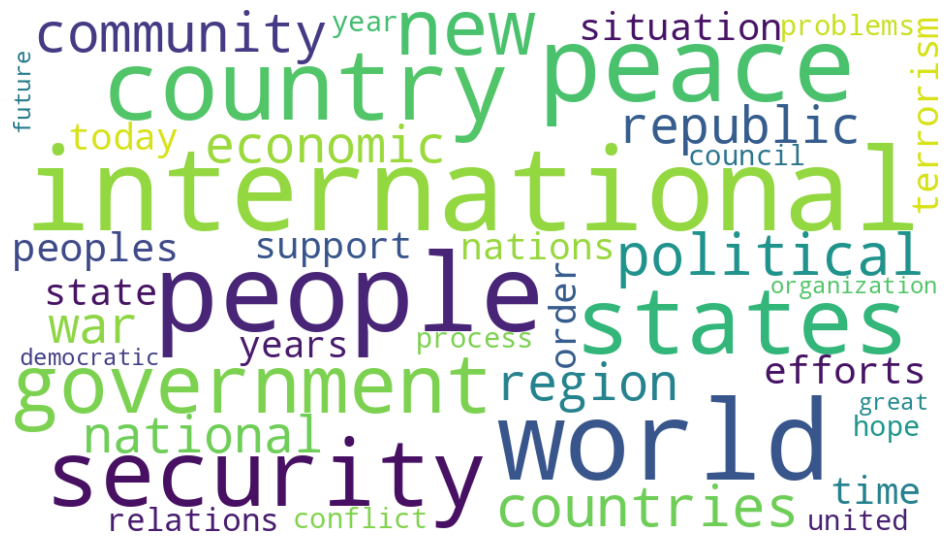

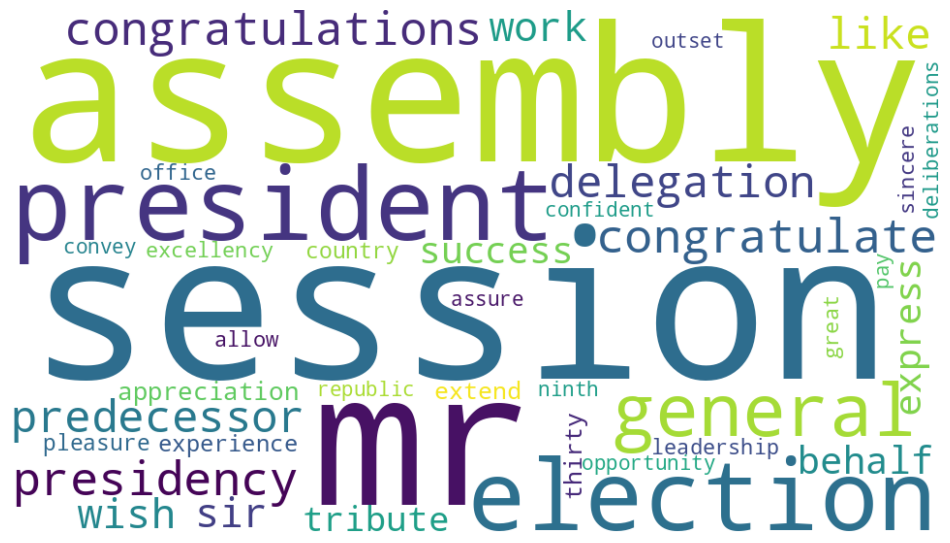

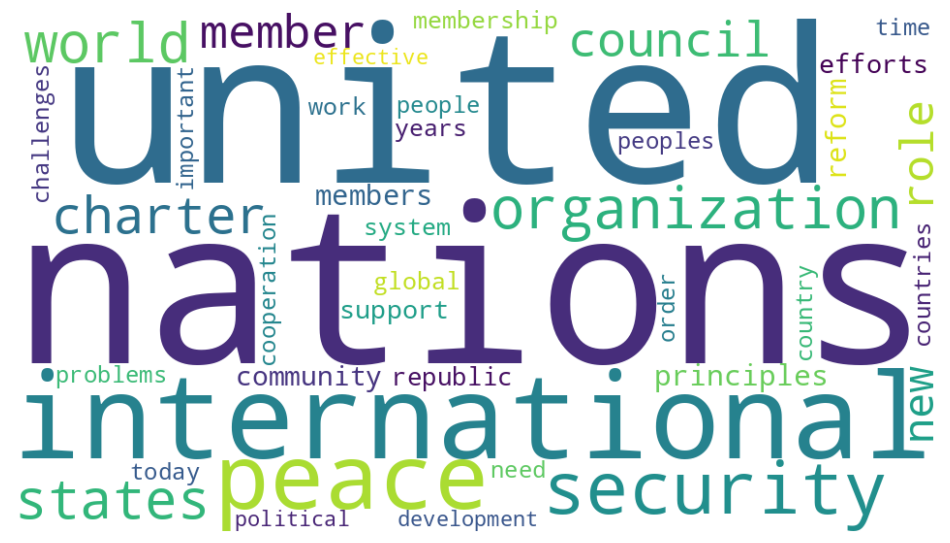

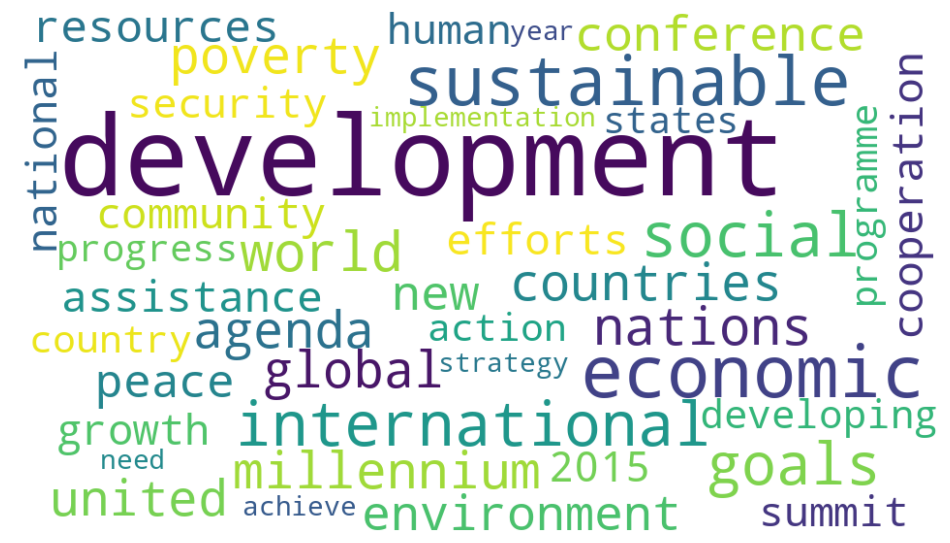

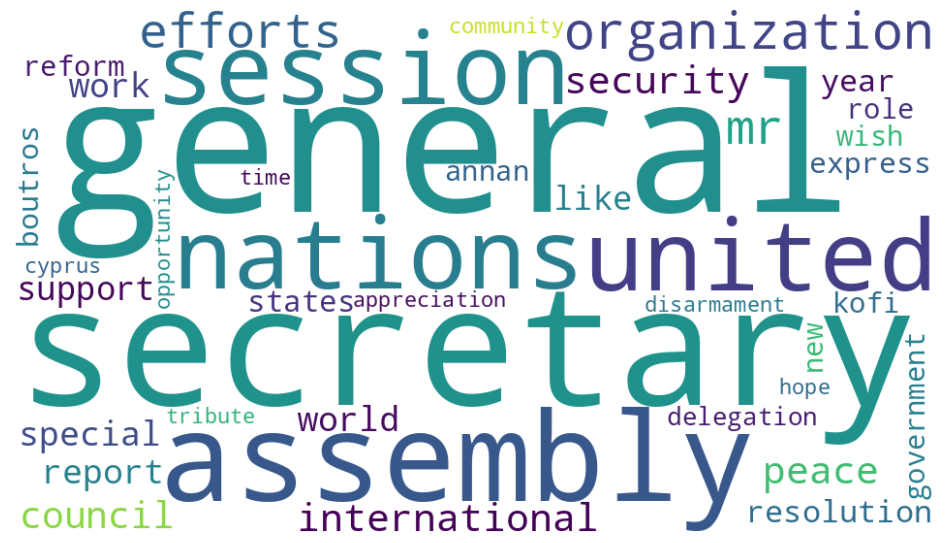

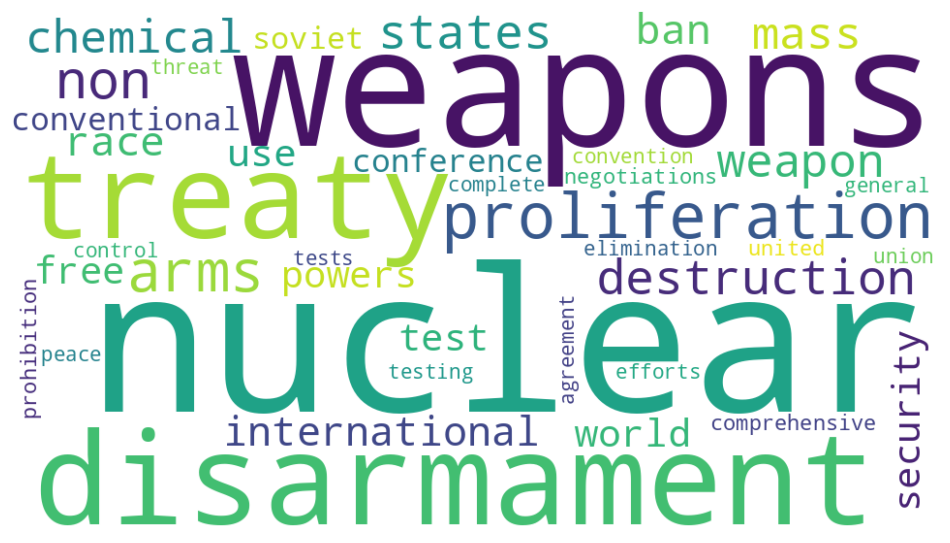

In [29]:
wordcloud_clusters(k_means_text, tfidf_para_vectors,tfidf_para_vectorizer.get_feature_names_out())

In [ ]:
tfidf_para_vectorizer

TfidfVectorizer(max_df=0.7, min_df=5,
                stop_words=['has', 'various', 'and', 'rather', 'there',
                            'already', 'may', '‘re', 'fifty', 'are', 'noone',
                            'eleven', "'ve", 'will', 'might', 'whereby', 'no',
                            'against', 'own', 'former', 'about', 'nine', "'m",
                            'more', 'others', 'whereupon', 'myself', 'so', '‘m',
                            'being', ...])